In [1]:
import pyspark
sc = pyspark.SparkContext(appName="text")
sc

<SparkContext master=local[*] appName=text>

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local").appName("text").getOrCreate()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
cols = ['sentiment','id','date','query_string','user','text']

In [12]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, names=cols, engine='python')

In [13]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [10]:
df.query_string.value_counts()

NO_QUERY    1600000
Name: query_string, dtype: int64

In [11]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [12]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
df[df.sentiment == 0].head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [14]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [15]:
# set sentiment 0, 4 --> 0, 1
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [16]:
df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [4]:
from pprint import pprint

In [18]:
df['pre_clean_len'] = [len(t) for t in df.text]
df.head(3)

,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89


In [19]:
data_dict = {
    'sentiment':{
    'type':df.sentiment.dtype,
    'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
    'type':df.text.dtype,
    'description':'tweet text'
    },
    'pre_clean_len':{
    'type':df.pre_clean_len.dtype,
    'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
data_dict

{'sentiment': {'type': dtype('int64'),
  'description': 'sentiment class - 0:negative, 1:positive'},
 'text': {'type': dtype('O'), 'description': 'tweet text'},
 'pre_clean_len': {'type': dtype('int64'),
  'description': 'Length of the tweet before cleaning'},
 'dataset_shape': (1600000, 3)}

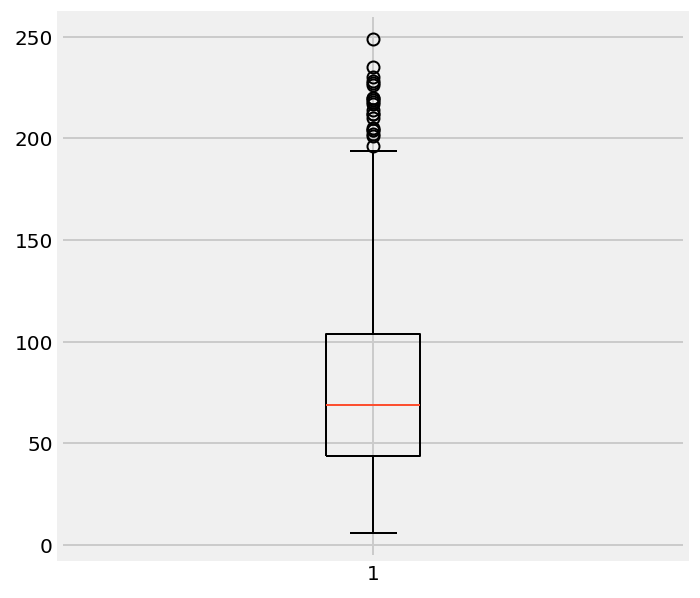

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [21]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141
1071,0,Used the term &quot;Fail Whale&quot; to a clie...,148


In [22]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [23]:
from bs4 import BeautifulSoup

In [24]:
example1 = BeautifulSoup(df.text[279], 'html5')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [25]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [26]:
import re

In [27]:
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [28]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [29]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [83]:
'''
df.text[226]
testing = df.text[226].decode("utf-8-sig")
testing.replace(u"\ufffd", "?")
'''

'\ntesting = df.text[226].decode("utf-8-sig")\ntesting.replace(u"�", "?")\n'

In [33]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [34]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [35]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

In [36]:
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html5')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [37]:
testing = df.text[:10]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

test_result

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera']

In [80]:
# 데이터 1프로만 샘플링
from tqdm import tqdm_notebook as tqdm

df_sample = df.sample(frac=0.01, replace=False)
print(len(df_sample))

16000


In [81]:
%%time
clean_tweet_texts = []
for i in tqdm(df_sample.text):
    clean_tweet_texts.append(tweet_cleaner(i))


Wall time: 7.87 s


In [82]:
len(clean_tweet_texts)

clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = list(df_sample['sentiment'])
clean_df.head(5)

,text,target
0,the van may become you re new home,0
1,nicki nope hate meds now my tummy feels a bit ...,0
2,can t see pretty faces but looks like a good time,0
3,good afternoon my left foot my ankle actually ...,4
4,morning enjoy this sun and tan my white bits l...,4


In [39]:
'''
%%time
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print("%d tweets has been processed" % (i+1))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))
'''

100000 tweets has been processed
Wall time: 1min 24s


In [44]:
'''
len(clean_tweet_texts)

clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head(3)
'''

160000

In [48]:
clean_df.to_csv('./documents/clean_tweet.csv',encoding='utf-8')

In [5]:
csv = './clean_tweet_0.01.csv'
my_df = pd.read_csv(csv, index_col=0)
my_df.head(3)

,text,target
0,i ll be trying it tomorrow it s dloading as we...,4
1,of course i downloaded careless whisper i m ki...,4
2,i am doing the housework i didn t do yesterday...,4


In [6]:
df = spark.read.option("header", "true") \
.option("nullValue", "?") \
.option("inferSchema", "true") \
.csv('./clean_tweet_0.01.csv')

In [7]:
df.take(5)

[Row(_c0=0, text='i ll be trying it tomorrow it s dloading as we speak', target=4),
 Row(_c0=1, text='of course i downloaded careless whisper i m kind of oded on wake me up though b c of the college bars in the midwest', target=4),
 Row(_c0=2, text='i am doing the housework i didn t do yesterday because i was playing taxicab', target=4),
 Row(_c0=3, text='missed a day and a half of twitter and can t possibly go through my updates me anything important i missed', target=4),
 Row(_c0=4, text='i am upset coz i have reached my search limit', target=0)]

In [8]:
df = df.dropna()
df.count()

15976

In [9]:
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed
= 2000)

In [10]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.feature import HashingTF, IDF, Tokenizer
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml import Pipeline

In [11]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

In [12]:
pipelineFit = pipeline.fit(train_set)

In [13]:
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)

In [14]:
train_df.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|_c0|                text|target|               words|                  tf|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|  0|i ll be trying it...|     4|[i, ll, be, tryin...|(65536,[16417,206...|(65536,[16417,206...|  1.0|
|  1|of course i downl...|     4|[of, course, i, d...|(65536,[731,9639,...|(65536,[731,9639,...|  1.0|
|  2|i am doing the ho...|     4|[i, am, doing, th...|(65536,[2934,6781...|(65536,[2934,6781...|  1.0|
|  3|missed a day and ...|     4|[missed, a, day, ...|(65536,[4991,9639...|(65536,[4991,9639...|  1.0|
|  4|i am upset coz i ...|     0|[i, am, upset, co...|(65536,[223,368,4...|(65536,[223,368,4...|  0.0|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [36]:
trSample = train_df.sample(0.01)

In [37]:
trSample.count()

15658

In [15]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = lrModel.transform(val_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8173515981735154

In [17]:
evaluator.getMetricName()

'areaUnderROC'

In [18]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.7655172413793103

In [20]:
from pyspark.ml.feature import CountVectorizer
tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

In [21]:
%%time
pipelineFit = pipeline.fit(train_set)

Wall time: 7.65 s


In [22]:
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)
print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7448
ROC-AUC: 0.8016


In [23]:
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

In [24]:
def build_trigrams(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
    cv = [
    CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
        outputCol="{0}_tf".format(i))
    for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+selector+lr)

In [25]:
%%time
# this take about 6 hours
# so don't run it unless you really indent to
trigram_pipelineFit = build_trigrams().fit(train_set)

Wall time: 6min 57s


In [26]:
predictions = trigram_pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)
# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7034
ROC-AUC: 0.7481


In [27]:
from pyspark.ml.feature import NGram, VectorAssembler

In [28]:
def build_ngrams_wocs(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [29]:
%%time
# it takes about 10 min
trigramwocs_pipelineFit = build_ngrams_wocs().fit(train_set)

Wall time: 21.6 s


In [30]:
predictions_wocs = trigramwocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())
roc_auc_wocs = evaluator.evaluate(predictions_wocs)
# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(accuracy_wocs))
print ("ROC-AUC: {0:.4f}".format(roc_auc_wocs))

Accuracy Score: 0.7034
ROC-AUC: 0.7481
